In [3]:
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install matplotlib
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers, utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [6]:
electrical_data = pd.read_csv("../../data/classification_dataset.csv")

print(electrical_data.describe())

                 G            C            B            A           Ia  \
count  7861.000000  7861.000000  7861.000000  7861.000000  7861.000000   
mean      0.432006     0.411271     0.555527     0.571429    13.721194   
std       0.495387     0.492095     0.496939     0.494903   464.741671   
min       0.000000     0.000000     0.000000     0.000000  -883.542316   
25%       0.000000     0.000000     0.000000     0.000000  -119.802518   
50%       0.000000     0.000000     1.000000     1.000000     2.042805   
75%       1.000000     1.000000     1.000000     1.000000   227.246377   
max       1.000000     1.000000     1.000000     1.000000   885.738571   

                Ib           Ic           Va           Vb           Vc  
count  7861.000000  7861.000000  7861.000000  7861.000000  7861.000000  
mean    -44.845268    34.392394    -0.007667     0.001152     0.006515  
std     439.269195   371.107412     0.289150     0.313437     0.307897  
min    -900.526951  -883.357762    -0.620

In [7]:
def encode_fault(row):
    return (int(row['G']), int(row['C']), int(row['B']), int(row['A']))

fault_tups = electrical_data.apply(encode_fault, axis=1)
labels, uniques = pd.factorize(fault_tups)  # labels are integers 0..(n_classes-1)
class_names = [ "G{}C{}B{}A{}".format(*t) for t in uniques ]
n_classes = len(uniques)
print("Unique label tuples (index -> tuple):")
for i, t in enumerate(uniques):
    print(i, t)

Unique label tuples (index -> tuple):
0 (1, 0, 0, 1)
1 (1, 0, 1, 1)
2 (0, 1, 1, 0)
3 (0, 1, 1, 1)
4 (1, 1, 1, 1)
5 (0, 0, 0, 0)


In [8]:
X = electrical_data[['Ia','Ib','Ic','Va','Vb','Vc']].values.astype(np.float32)
y = labels  # integer labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [9]:
### Preprocessing functions

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

def preprocess_standard_scale(X_train, X_test):
    """
    Fit StandardScaler on X_train and transform X_train/X_test.
    Returns: scaler, X_train_scaled, X_test_scaled
    """
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    return X_train_s, X_test_s

def preprocess_poly_and_scale(X_train, X_test, degree=2):
    """
    Polynomial feature expansion followed by standard scaling.
    Returns: pipeline (fitted), X_train_transformed, X_test_transformed
    """
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    scaler = StandardScaler()
    # Fit poly on training, transform both
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly  = poly.transform(X_test)
    # Fit scaler on polynomial features
    X_train_ps = scaler.fit_transform(X_train_poly)
    X_test_ps  = scaler.transform(X_test_poly)
    # return a tuple with fitted components in case user wants them
    pipeline = {"poly": poly, "scaler": scaler}
    return X_train_ps, X_test_ps

In [12]:
### LR, DT, RF models

import models as md
from sklearn.metrics import accuracy_score

model_dictionary = { # each value includes tuple: (model_build(), Preprocessing: "Scaling/ScalPoly/None")
    "Logistic Regression (Initial)": (md.build_initial_lr(), "Scaling"),
    "Logistic Regression (Improved)": (md.build_improved_lr(), "ScalPoly"),
    "Decision Tree (Initial)": (md.build_initial_dt(), "Scaling"),
    "Decision Tree (Improved)": (md.build_improved_dt(), "None"),
    "Random Forest (Initial)": (md.build_initial_rf(), "None"),
    "Random Forest (Improved)": (md.build_improved_rf(), "None")
}



print(f"{'='*60}")
print(f"{'SCIKIT-LEARN MODEL EVALUATION':^60}")
print(f"{'='*60}\n")

for name, val in model_dictionary.items():
    print(f"Training {name}...")
    
    
    # Apply preprocessing to the model accordingly
    model = val[0]
    X_train_pr = None
    X_test_pr = None
    if val[1]=="Scaling":
        X_train_pr, X_test_pr = preprocess_standard_scale(X_train, X_test)
    elif val[1]=="ScalPoly":
        X_train_pr, X_test_pr = preprocess_poly_and_scale(X_train, X_test)
    else:
        X_train_pr, X_test_pr = X_train, X_test
    


    # Fit the models to the training data
    model.fit(X_train_pr, y_train)
    
    # Generate predictions on the unseen test set
    y_pred = model.predict(X_test_pr)
    
    # C. EVALUATE: Compare predictions (y_pred) to actuals (y_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"--> Accuracy: {acc:.4f}")
    
    # Print the full classification report (Precision, Recall, F1)
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    print("-" * 60)

               SCIKIT-LEARN MODEL EVALUATION                

Training Logistic Regression (Initial)...
--> Accuracy: 0.3433
Classification Report for Logistic Regression (Initial):
              precision    recall  f1-score   support

    G1C0B0A1       0.00      0.00      0.00       226
    G1C0B1A1       1.00      0.12      0.22       227
    G0C1B1A0       0.00      0.00      0.00       201
    G0C1B1A1       0.16      0.02      0.04       219
    G1C1B1A1       0.45      0.15      0.23       227
    G0C0B0A0       0.33      1.00      0.49       473

    accuracy                           0.34      1573
   macro avg       0.32      0.22      0.16      1573
weighted avg       0.33      0.34      0.22      1573

------------------------------------------------------------
Training Logistic Regression (Improved)...


/Users/nathanielcorey/Library/Application Support/hatch/env/virtual/electrical-fault-detection-and-classification/CGtv8zCn/electrical-fault-detection-and-classification/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/nathanielcorey/Library/Application Support/hatch/env/virtual/electrical-fault-detection-and-classification/CGtv8zCn/electrical-fault-detection-and-classification/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nathanielcorey/Library/Application Support/hatch/env/virtual/electrical

--> Accuracy: 0.9224
Classification Report for Logistic Regression (Improved):
              precision    recall  f1-score   support

    G1C0B0A1       1.00      1.00      1.00       226
    G1C0B1A1       1.00      1.00      1.00       227
    G0C1B1A0       1.00      1.00      1.00       201
    G0C1B1A1       0.73      0.71      0.72       219
    G1C1B1A1       0.73      0.75      0.74       227
    G0C0B0A0       1.00      1.00      1.00       473

    accuracy                           0.92      1573
   macro avg       0.91      0.91      0.91      1573
weighted avg       0.92      0.92      0.92      1573

------------------------------------------------------------
Training Decision Tree (Initial)...
--> Accuracy: 0.8837
Classification Report for Decision Tree (Initial):
              precision    recall  f1-score   support

    G1C0B0A1       1.00      1.00      1.00       226
    G1C0B1A1       1.00      0.99      0.99       227
    G0C1B1A0       1.00      1.00      1.00   

In [ ]:
### Neural Network MLP Classifier
import models as md

model = md.build_initial_mlp(X_train.shape[1], n_classes)

model.compile(

    loss='sparse_categorical_crossentropy',   # because y are integer labels

    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),

    metrics=['accuracy']

)

model.summary()

In [ ]:
early_stop = callbacks.EarlyStopping( # avoids overfitting by halting training if validation loss stops improving for 12 epochs
    monitor='val_loss',
    patience=12,
    restore_best_weights=True)

check = callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=200,
    batch_size=64,
    callbacks=[early_stop, check],
    # class_weight=class_weights,   # uncomment if you computed class_weights
    verbose=2
)


test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}  Test loss: {test_loss:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=class_names))

print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, y_pred))

Epoch 1/200


84/84 - 1s - 13ms/step - accuracy: 0.4463 - loss: 1.4014 - val_accuracy: 0.6186 - val_loss: 1.2622
Epoch 2/200


84/84 - 0s - 1ms/step - accuracy: 0.6370 - loss: 0.8893 - val_accuracy: 0.6864 - val_loss: 0.9103
Epoch 3/200


84/84 - 0s - 1ms/step - accuracy: 0.7028 - loss: 0.7136 - val_accuracy: 0.7415 - val_loss: 0.6714
Epoch 4/200


84/84 - 0s - 1ms/step - accuracy: 0.7259 - loss: 0.6291 - val_accuracy: 0.7998 - val_loss: 0.5304
Epoch 5/200


84/84 - 0s - 1ms/step - accuracy: 0.7339 - loss: 0.5835 - val_accuracy: 0.8019 - val_loss: 0.4493
Epoch 6/200


84/84 - 0s - 1ms/step - accuracy: 0.7528 - loss: 0.5322 - val_accuracy: 0.8231 - val_loss: 0.3966
Epoch 7/200


84/84 - 0s - 1ms/step - accuracy: 0.7625 - loss: 0.5115 - val_accuracy: 0.8369 - val_loss: 0.3684
Epoch 8/200


84/84 - 0s - 1ms/step - accuracy: 0.7633 - loss: 0.4855 - val_accuracy: 0.8210 - val_loss: 0.3591
Epoch 9/200


84/84 - 0s - 1ms/step - accuracy: 0.7769 - loss: 0.4590 - val_accuracy: 0.8273 - val_loss: 0.3397
Epoch 10/200


84/84 - 0s - 1ms/step - accuracy: 0.7867 - loss: 0.4469 - val_accuracy: 0.8475 - val_loss: 0.3337
Epoch 11/200


84/84 - 0s - 1ms/step - accuracy: 0.7942 - loss: 0.4258 - val_accuracy: 0.8443 - val_loss: 0.3169
Epoch 12/200


84/84 - 0s - 1ms/step - accuracy: 0.7955 - loss: 0.4136 - val_accuracy: 0.8337 - val_loss: 0.3161
Epoch 13/200


84/84 - 0s - 996us/step - accuracy: 0.7949 - loss: 0.4040 - val_accuracy: 0.8273 - val_loss: 0.3106
Epoch 14/200


84/84 - 0s - 997us/step - accuracy: 0.7929 - loss: 0.4080 - val_accuracy: 0.8294 - val_loss: 0.3051
Epoch 15/200


84/84 - 0s - 1ms/step - accuracy: 0.7983 - loss: 0.3941 - val_accuracy: 0.8464 - val_loss: 0.2955
Epoch 16/200


84/84 - 0s - 1ms/step - accuracy: 0.8050 - loss: 0.3866 - val_accuracy: 0.8369 - val_loss: 0.2878
Epoch 17/200
84/84 - 0s - 923us/step - accuracy: 0.7996 - loss: 0.3829 - val_accuracy: 0.8422 - val_loss: 0.2897
Epoch 18/200
84/84 - 0s - 851us/step - accuracy: 0.8020 - loss: 0.3704 - val_accuracy: 0.8305 - val_loss: 0.2894
Epoch 19/200


84/84 - 0s - 947us/step - accuracy: 0.8065 - loss: 0.3678 - val_accuracy: 0.8379 - val_loss: 0.2813
Epoch 20/200


84/84 - 0s - 992us/step - accuracy: 0.8082 - loss: 0.3699 - val_accuracy: 0.8517 - val_loss: 0.2769
Epoch 21/200
84/84 - 0s - 900us/step - accuracy: 0.8104 - loss: 0.3619 - val_accuracy: 0.8316 - val_loss: 0.2835
Epoch 22/200


84/84 - 0s - 961us/step - accuracy: 0.8073 - loss: 0.3594 - val_accuracy: 0.8379 - val_loss: 0.2765
Epoch 23/200


84/84 - 0s - 1ms/step - accuracy: 0.8101 - loss: 0.3487 - val_accuracy: 0.8506 - val_loss: 0.2698
Epoch 24/200


84/84 - 0s - 1ms/step - accuracy: 0.8192 - loss: 0.3476 - val_accuracy: 0.8400 - val_loss: 0.2682
Epoch 25/200
84/84 - 0s - 903us/step - accuracy: 0.8149 - loss: 0.3506 - val_accuracy: 0.8390 - val_loss: 0.2695
Epoch 26/200


84/84 - 0s - 1ms/step - accuracy: 0.8121 - loss: 0.3430 - val_accuracy: 0.8432 - val_loss: 0.2602
Epoch 27/200
84/84 - 0s - 1ms/step - accuracy: 0.8213 - loss: 0.3438 - val_accuracy: 0.8443 - val_loss: 0.2651
Epoch 28/200
84/84 - 0s - 1ms/step - accuracy: 0.8177 - loss: 0.3380 - val_accuracy: 0.8422 - val_loss: 0.2628
Epoch 29/200
84/84 - 0s - 889us/step - accuracy: 0.8217 - loss: 0.3340 - val_accuracy: 0.8453 - val_loss: 0.2617
Epoch 30/200


84/84 - 0s - 991us/step - accuracy: 0.8166 - loss: 0.3345 - val_accuracy: 0.8506 - val_loss: 0.2557
Epoch 31/200
84/84 - 0s - 999us/step - accuracy: 0.8196 - loss: 0.3277 - val_accuracy: 0.8475 - val_loss: 0.2599
Epoch 32/200


84/84 - 0s - 1ms/step - accuracy: 0.8183 - loss: 0.3338 - val_accuracy: 0.8443 - val_loss: 0.2543
Epoch 33/200
84/84 - 0s - 980us/step - accuracy: 0.8228 - loss: 0.3182 - val_accuracy: 0.8432 - val_loss: 0.2544
Epoch 34/200


84/84 - 0s - 1ms/step - accuracy: 0.8249 - loss: 0.3216 - val_accuracy: 0.8538 - val_loss: 0.2443
Epoch 35/200
84/84 - 0s - 1ms/step - accuracy: 0.8239 - loss: 0.3126 - val_accuracy: 0.8496 - val_loss: 0.2488
Epoch 36/200
84/84 - 0s - 1ms/step - accuracy: 0.8237 - loss: 0.3166 - val_accuracy: 0.8422 - val_loss: 0.2549
Epoch 37/200
84/84 - 0s - 958us/step - accuracy: 0.8263 - loss: 0.3145 - val_accuracy: 0.8496 - val_loss: 0.2476
Epoch 38/200
84/84 - 0s - 897us/step - accuracy: 0.8172 - loss: 0.3125 - val_accuracy: 0.8549 - val_loss: 0.2508
Epoch 39/200


84/84 - 0s - 1ms/step - accuracy: 0.8243 - loss: 0.3137 - val_accuracy: 0.8538 - val_loss: 0.2355
Epoch 40/200
84/84 - 0s - 980us/step - accuracy: 0.8263 - loss: 0.3083 - val_accuracy: 0.8496 - val_loss: 0.2419
Epoch 41/200
84/84 - 0s - 1ms/step - accuracy: 0.8263 - loss: 0.3068 - val_accuracy: 0.8591 - val_loss: 0.2362
Epoch 42/200
84/84 - 0s - 925us/step - accuracy: 0.8205 - loss: 0.3055 - val_accuracy: 0.8411 - val_loss: 0.2365
Epoch 43/200
84/84 - 0s - 931us/step - accuracy: 0.8293 - loss: 0.3023 - val_accuracy: 0.8390 - val_loss: 0.2371
Epoch 44/200
84/84 - 0s - 967us/step - accuracy: 0.8297 - loss: 0.2996 - val_accuracy: 0.8422 - val_loss: 0.2373
Epoch 45/200


84/84 - 0s - 1ms/step - accuracy: 0.8243 - loss: 0.3065 - val_accuracy: 0.8443 - val_loss: 0.2315
Epoch 46/200
84/84 - 0s - 995us/step - accuracy: 0.8329 - loss: 0.2944 - val_accuracy: 0.8496 - val_loss: 0.2362
Epoch 47/200


84/84 - 0s - 1ms/step - accuracy: 0.8263 - loss: 0.2916 - val_accuracy: 0.8538 - val_loss: 0.2267
Epoch 48/200


84/84 - 0s - 1ms/step - accuracy: 0.8282 - loss: 0.2968 - val_accuracy: 0.8538 - val_loss: 0.2231
Epoch 49/200
84/84 - 0s - 1ms/step - accuracy: 0.8247 - loss: 0.2935 - val_accuracy: 0.8475 - val_loss: 0.2332
Epoch 50/200
84/84 - 0s - 951us/step - accuracy: 0.8293 - loss: 0.2982 - val_accuracy: 0.8517 - val_loss: 0.2306
Epoch 51/200
84/84 - 0s - 1ms/step - accuracy: 0.8350 - loss: 0.2845 - val_accuracy: 0.8485 - val_loss: 0.2284
Epoch 52/200
84/84 - 0s - 949us/step - accuracy: 0.8312 - loss: 0.2865 - val_accuracy: 0.8528 - val_loss: 0.2379
Epoch 53/200


84/84 - 0s - 1ms/step - accuracy: 0.8277 - loss: 0.2934 - val_accuracy: 0.8549 - val_loss: 0.2176
Epoch 54/200
84/84 - 0s - 1ms/step - accuracy: 0.8288 - loss: 0.2915 - val_accuracy: 0.8686 - val_loss: 0.2197
Epoch 55/200
84/84 - 0s - 1ms/step - accuracy: 0.8391 - loss: 0.2848 - val_accuracy: 0.8612 - val_loss: 0.2255
Epoch 56/200
84/84 - 0s - 967us/step - accuracy: 0.8346 - loss: 0.2830 - val_accuracy: 0.8517 - val_loss: 0.2210
Epoch 57/200
84/84 - 0s - 925us/step - accuracy: 0.8308 - loss: 0.2800 - val_accuracy: 0.8549 - val_loss: 0.2250
Epoch 58/200
84/84 - 0s - 963us/step - accuracy: 0.8396 - loss: 0.2772 - val_accuracy: 0.8528 - val_loss: 0.2198
Epoch 59/200
84/84 - 0s - 943us/step - accuracy: 0.8338 - loss: 0.2837 - val_accuracy: 0.8453 - val_loss: 0.2279
Epoch 60/200
84/84 - 0s - 948us/step - accuracy: 0.8340 - loss: 0.2831 - val_accuracy: 0.8665 - val_loss: 0.2249
Epoch 61/200


84/84 - 0s - 1ms/step - accuracy: 0.8350 - loss: 0.2821 - val_accuracy: 0.8570 - val_loss: 0.2150
Epoch 62/200
84/84 - 0s - 1ms/step - accuracy: 0.8344 - loss: 0.2800 - val_accuracy: 0.8517 - val_loss: 0.2160
Epoch 63/200


84/84 - 0s - 1ms/step - accuracy: 0.8370 - loss: 0.2765 - val_accuracy: 0.8623 - val_loss: 0.2081
Epoch 64/200
84/84 - 0s - 987us/step - accuracy: 0.8436 - loss: 0.2742 - val_accuracy: 0.8708 - val_loss: 0.2107
Epoch 65/200


84/84 - 0s - 1ms/step - accuracy: 0.8336 - loss: 0.2810 - val_accuracy: 0.8633 - val_loss: 0.2062
Epoch 66/200
84/84 - 0s - 994us/step - accuracy: 0.8363 - loss: 0.2666 - val_accuracy: 0.8633 - val_loss: 0.2147
Epoch 67/200
84/84 - 0s - 935us/step - accuracy: 0.8357 - loss: 0.2663 - val_accuracy: 0.8581 - val_loss: 0.2111
Epoch 68/200
84/84 - 0s - 930us/step - accuracy: 0.8355 - loss: 0.2741 - val_accuracy: 0.8602 - val_loss: 0.2091
Epoch 69/200
84/84 - 0s - 877us/step - accuracy: 0.8391 - loss: 0.2689 - val_accuracy: 0.8549 - val_loss: 0.2106
Epoch 70/200


84/84 - 0s - 983us/step - accuracy: 0.8438 - loss: 0.2704 - val_accuracy: 0.8644 - val_loss: 0.2056
Epoch 71/200


84/84 - 0s - 1ms/step - accuracy: 0.8394 - loss: 0.2644 - val_accuracy: 0.8559 - val_loss: 0.2030
Epoch 72/200
84/84 - 0s - 1ms/step - accuracy: 0.8359 - loss: 0.2749 - val_accuracy: 0.8581 - val_loss: 0.2087
Epoch 73/200
84/84 - 0s - 1ms/step - accuracy: 0.8462 - loss: 0.2600 - val_accuracy: 0.8644 - val_loss: 0.2044
Epoch 74/200
84/84 - 0s - 917us/step - accuracy: 0.8385 - loss: 0.2675 - val_accuracy: 0.8644 - val_loss: 0.2097
Epoch 75/200
84/84 - 0s - 925us/step - accuracy: 0.8466 - loss: 0.2600 - val_accuracy: 0.8623 - val_loss: 0.2066
Epoch 76/200
84/84 - 0s - 935us/step - accuracy: 0.8374 - loss: 0.2666 - val_accuracy: 0.8528 - val_loss: 0.2115
Epoch 77/200
84/84 - 0s - 939us/step - accuracy: 0.8417 - loss: 0.2672 - val_accuracy: 0.8633 - val_loss: 0.2143
Epoch 78/200
84/84 - 0s - 945us/step - accuracy: 0.8445 - loss: 0.2599 - val_accuracy: 0.8549 - val_loss: 0.2082
Epoch 79/200


84/84 - 0s - 984us/step - accuracy: 0.8394 - loss: 0.2580 - val_accuracy: 0.8803 - val_loss: 0.1989
Epoch 80/200
84/84 - 0s - 1ms/step - accuracy: 0.8441 - loss: 0.2612 - val_accuracy: 0.8581 - val_loss: 0.2067
Epoch 81/200
84/84 - 0s - 2ms/step - accuracy: 0.8406 - loss: 0.2636 - val_accuracy: 0.8528 - val_loss: 0.2130
Epoch 82/200
84/84 - 0s - 1ms/step - accuracy: 0.8443 - loss: 0.2608 - val_accuracy: 0.8686 - val_loss: 0.2072
Epoch 83/200
84/84 - 0s - 1ms/step - accuracy: 0.8439 - loss: 0.2561 - val_accuracy: 0.8538 - val_loss: 0.2037
Epoch 84/200
84/84 - 0s - 1ms/step - accuracy: 0.8499 - loss: 0.2503 - val_accuracy: 0.8602 - val_loss: 0.2012
Epoch 85/200
84/84 - 0s - 972us/step - accuracy: 0.8464 - loss: 0.2599 - val_accuracy: 0.8633 - val_loss: 0.2000
Epoch 86/200
84/84 - 0s - 935us/step - accuracy: 0.8469 - loss: 0.2536 - val_accuracy: 0.8655 - val_loss: 0.1998
Epoch 87/200
84/84 - 0s - 982us/step - accuracy: 0.8383 - loss: 0.2673 - val_accuracy: 0.8559 - val_loss: 0.2058
Epoch 

84/84 - 0s - 1ms/step - accuracy: 0.8460 - loss: 0.2564 - val_accuracy: 0.8612 - val_loss: 0.1985
Epoch 89/200
84/84 - 0s - 1ms/step - accuracy: 0.8503 - loss: 0.2464 - val_accuracy: 0.8602 - val_loss: 0.2045
Epoch 90/200
84/84 - 0s - 994us/step - accuracy: 0.8426 - loss: 0.2491 - val_accuracy: 0.8602 - val_loss: 0.1986
Epoch 91/200


84/84 - 0s - 1ms/step - accuracy: 0.8449 - loss: 0.2532 - val_accuracy: 0.8644 - val_loss: 0.1952
Epoch 92/200
84/84 - 0s - 1ms/step - accuracy: 0.8449 - loss: 0.2605 - val_accuracy: 0.8655 - val_loss: 0.1995
Epoch 93/200
84/84 - 0s - 998us/step - accuracy: 0.8449 - loss: 0.2600 - val_accuracy: 0.8623 - val_loss: 0.2116
Epoch 94/200
84/84 - 0s - 945us/step - accuracy: 0.8490 - loss: 0.2512 - val_accuracy: 0.8549 - val_loss: 0.2056
Epoch 95/200
84/84 - 0s - 923us/step - accuracy: 0.8445 - loss: 0.2507 - val_accuracy: 0.8623 - val_loss: 0.2014
Epoch 96/200


84/84 - 0s - 1ms/step - accuracy: 0.8430 - loss: 0.2574 - val_accuracy: 0.8665 - val_loss: 0.1936
Epoch 97/200
84/84 - 0s - 1ms/step - accuracy: 0.8415 - loss: 0.2551 - val_accuracy: 0.8686 - val_loss: 0.2037
Epoch 98/200
84/84 - 0s - 956us/step - accuracy: 0.8559 - loss: 0.2426 - val_accuracy: 0.8581 - val_loss: 0.1998
Epoch 99/200
84/84 - 0s - 942us/step - accuracy: 0.8434 - loss: 0.2568 - val_accuracy: 0.8729 - val_loss: 0.1977
Epoch 100/200
84/84 - 0s - 951us/step - accuracy: 0.8501 - loss: 0.2477 - val_accuracy: 0.8581 - val_loss: 0.1969
Epoch 101/200
84/84 - 0s - 952us/step - accuracy: 0.8466 - loss: 0.2480 - val_accuracy: 0.8633 - val_loss: 0.1987
Epoch 102/200


84/84 - 0s - 1ms/step - accuracy: 0.8486 - loss: 0.2472 - val_accuracy: 0.8623 - val_loss: 0.1934
Epoch 103/200
84/84 - 0s - 1ms/step - accuracy: 0.8481 - loss: 0.2447 - val_accuracy: 0.8528 - val_loss: 0.2035
Epoch 104/200
84/84 - 0s - 924us/step - accuracy: 0.8467 - loss: 0.2550 - val_accuracy: 0.8655 - val_loss: 0.1972
Epoch 105/200


84/84 - 0s - 1ms/step - accuracy: 0.8533 - loss: 0.2420 - val_accuracy: 0.8739 - val_loss: 0.1931
Epoch 106/200
84/84 - 0s - 1ms/step - accuracy: 0.8462 - loss: 0.2441 - val_accuracy: 0.8686 - val_loss: 0.1957
Epoch 107/200
84/84 - 0s - 946us/step - accuracy: 0.8484 - loss: 0.2463 - val_accuracy: 0.8676 - val_loss: 0.1989
Epoch 108/200
84/84 - 0s - 921us/step - accuracy: 0.8424 - loss: 0.2461 - val_accuracy: 0.8591 - val_loss: 0.1959
Epoch 109/200
84/84 - 0s - 909us/step - accuracy: 0.8449 - loss: 0.2474 - val_accuracy: 0.8676 - val_loss: 0.1976
Epoch 110/200
84/84 - 0s - 907us/step - accuracy: 0.8481 - loss: 0.2463 - val_accuracy: 0.8697 - val_loss: 0.1953
Epoch 111/200
84/84 - 0s - 905us/step - accuracy: 0.8464 - loss: 0.2451 - val_accuracy: 0.8517 - val_loss: 0.1960
Epoch 112/200
84/84 - 0s - 893us/step - accuracy: 0.8456 - loss: 0.2411 - val_accuracy: 0.8612 - val_loss: 0.2004
Epoch 113/200
84/84 - 0s - 913us/step - accuracy: 0.8501 - loss: 0.2398 - val_accuracy: 0.8623 - val_loss:

84/84 - 0s - 999us/step - accuracy: 0.8423 - loss: 0.2446 - val_accuracy: 0.8708 - val_loss: 0.1929
Epoch 117/200
84/84 - 0s - 968us/step - accuracy: 0.8527 - loss: 0.2346 - val_accuracy: 0.8528 - val_loss: 0.1937
Epoch 118/200


84/84 - 0s - 1ms/step - accuracy: 0.8518 - loss: 0.2408 - val_accuracy: 0.8602 - val_loss: 0.1918
Epoch 119/200
84/84 - 0s - 1ms/step - accuracy: 0.8475 - loss: 0.2398 - val_accuracy: 0.8729 - val_loss: 0.2005
Epoch 120/200
84/84 - 0s - 912us/step - accuracy: 0.8432 - loss: 0.2441 - val_accuracy: 0.8686 - val_loss: 0.1980
Epoch 121/200
84/84 - 0s - 900us/step - accuracy: 0.8481 - loss: 0.2366 - val_accuracy: 0.8686 - val_loss: 0.1946
Epoch 122/200
84/84 - 0s - 931us/step - accuracy: 0.8488 - loss: 0.2386 - val_accuracy: 0.8655 - val_loss: 0.1976
Epoch 123/200


84/84 - 0s - 1ms/step - accuracy: 0.8525 - loss: 0.2409 - val_accuracy: 0.8771 - val_loss: 0.1902
Epoch 124/200
84/84 - 0s - 1ms/step - accuracy: 0.8430 - loss: 0.2486 - val_accuracy: 0.8633 - val_loss: 0.1983
Epoch 125/200
84/84 - 0s - 930us/step - accuracy: 0.8510 - loss: 0.2450 - val_accuracy: 0.8676 - val_loss: 0.1939
Epoch 126/200
84/84 - 0s - 921us/step - accuracy: 0.8509 - loss: 0.2434 - val_accuracy: 0.8718 - val_loss: 0.1909
Epoch 127/200
84/84 - 0s - 937us/step - accuracy: 0.8400 - loss: 0.2460 - val_accuracy: 0.8517 - val_loss: 0.1968
Epoch 128/200
84/84 - 0s - 913us/step - accuracy: 0.8451 - loss: 0.2454 - val_accuracy: 0.8644 - val_loss: 0.1949
Epoch 129/200
84/84 - 0s - 908us/step - accuracy: 0.8496 - loss: 0.2433 - val_accuracy: 0.8581 - val_loss: 0.1929
Epoch 130/200
84/84 - 0s - 922us/step - accuracy: 0.8439 - loss: 0.2452 - val_accuracy: 0.8729 - val_loss: 0.1946
Epoch 131/200
84/84 - 0s - 935us/step - accuracy: 0.8514 - loss: 0.2372 - val_accuracy: 0.8496 - val_loss:

84/84 - 0s - 1ms/step - accuracy: 0.8490 - loss: 0.2327 - val_accuracy: 0.8665 - val_loss: 0.1901
Epoch 135/200
84/84 - 0s - 948us/step - accuracy: 0.8582 - loss: 0.2374 - val_accuracy: 0.8708 - val_loss: 0.1987
Epoch 136/200
84/84 - 0s - 884us/step - accuracy: 0.8514 - loss: 0.2369 - val_accuracy: 0.8676 - val_loss: 0.1907
Epoch 137/200
84/84 - 0s - 889us/step - accuracy: 0.8518 - loss: 0.2392 - val_accuracy: 0.8686 - val_loss: 0.1933
Epoch 138/200
84/84 - 0s - 896us/step - accuracy: 0.8509 - loss: 0.2396 - val_accuracy: 0.8602 - val_loss: 0.1985
Epoch 139/200
84/84 - 0s - 924us/step - accuracy: 0.8494 - loss: 0.2347 - val_accuracy: 0.8708 - val_loss: 0.1943
Epoch 140/200
84/84 - 0s - 907us/step - accuracy: 0.8481 - loss: 0.2413 - val_accuracy: 0.8686 - val_loss: 0.1952
Epoch 141/200


84/84 - 0s - 1ms/step - accuracy: 0.8561 - loss: 0.2368 - val_accuracy: 0.8612 - val_loss: 0.1893
Epoch 142/200
84/84 - 0s - 982us/step - accuracy: 0.8466 - loss: 0.2448 - val_accuracy: 0.8591 - val_loss: 0.2017
Epoch 143/200
84/84 - 0s - 1ms/step - accuracy: 0.8522 - loss: 0.2382 - val_accuracy: 0.8686 - val_loss: 0.1910
Epoch 144/200
84/84 - 0s - 912us/step - accuracy: 0.8423 - loss: 0.2450 - val_accuracy: 0.8623 - val_loss: 0.1907
Epoch 145/200
84/84 - 0s - 933us/step - accuracy: 0.8445 - loss: 0.2400 - val_accuracy: 0.8676 - val_loss: 0.1894
Epoch 146/200
84/84 - 0s - 925us/step - accuracy: 0.8555 - loss: 0.2342 - val_accuracy: 0.8623 - val_loss: 0.1904
Epoch 147/200
84/84 - 0s - 911us/step - accuracy: 0.8552 - loss: 0.2339 - val_accuracy: 0.8686 - val_loss: 0.1920
Epoch 148/200
84/84 - 0s - 912us/step - accuracy: 0.8512 - loss: 0.2440 - val_accuracy: 0.8602 - val_loss: 0.2003
Epoch 149/200
84/84 - 0s - 949us/step - accuracy: 0.8473 - loss: 0.2364 - val_accuracy: 0.8761 - val_loss:

84/84 - 0s - 1ms/step - accuracy: 0.8479 - loss: 0.2352 - val_accuracy: 0.8729 - val_loss: 0.1875
Epoch 154/200


84/84 - 0s - 1ms/step - accuracy: 0.8492 - loss: 0.2416 - val_accuracy: 0.8623 - val_loss: 0.1856
Epoch 155/200
84/84 - 0s - 961us/step - accuracy: 0.8525 - loss: 0.2279 - val_accuracy: 0.8718 - val_loss: 0.1877
Epoch 156/200
84/84 - 0s - 951us/step - accuracy: 0.8460 - loss: 0.2457 - val_accuracy: 0.8708 - val_loss: 0.1956
Epoch 157/200
84/84 - 0s - 921us/step - accuracy: 0.8479 - loss: 0.2477 - val_accuracy: 0.8782 - val_loss: 0.1891
Epoch 158/200
84/84 - 0s - 890us/step - accuracy: 0.8482 - loss: 0.2435 - val_accuracy: 0.8686 - val_loss: 0.1902
Epoch 159/200
84/84 - 0s - 916us/step - accuracy: 0.8514 - loss: 0.2377 - val_accuracy: 0.8729 - val_loss: 0.1911
Epoch 160/200
84/84 - 0s - 888us/step - accuracy: 0.8481 - loss: 0.2380 - val_accuracy: 0.8591 - val_loss: 0.1948
Epoch 161/200
84/84 - 0s - 900us/step - accuracy: 0.8426 - loss: 0.2348 - val_accuracy: 0.8729 - val_loss: 0.1910
Epoch 162/200
84/84 - 0s - 921us/step - accuracy: 0.8509 - loss: 0.2337 - val_accuracy: 0.8708 - val_los

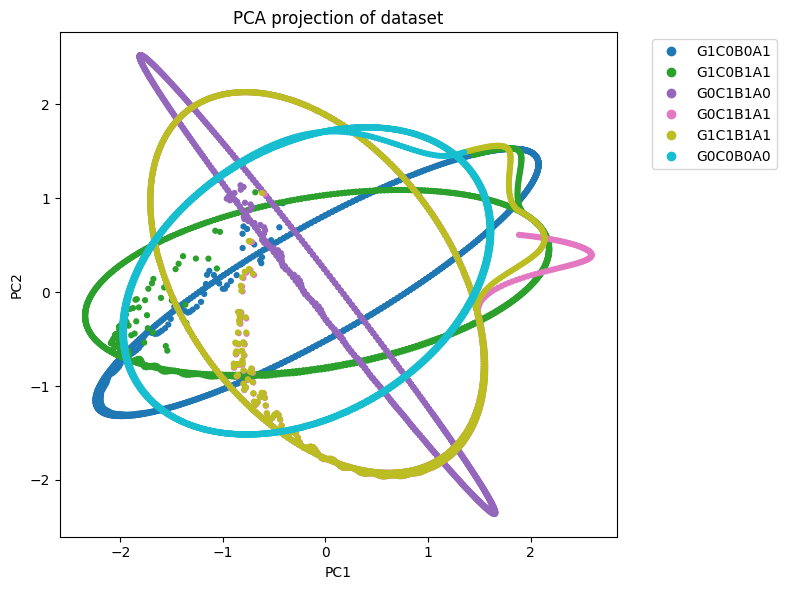

In [ ]:
pca = PCA(n_components=2) # reduces 6D features space to 2 dimensions that capture the most variance 
X_pca = pca.fit_transform(scaler.transform(X))  # plot entire dataset
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10', s=12)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names, bbox_to_anchor=(1.05, 1))
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA projection of dataset')
plt.tight_layout()
plt.show()